##  Team Members

- # Taksh Pal 24/B03/048
- # Ritij Raj 24/B03/015
# SAR to EO Image Translation using CycleGAN

This project implements a **Cycle-Consistent Generative Adversarial Network (CycleGAN)** for translating **Synthetic Aperture Radar (SAR)** satellite images to **Electro-Optical (EO)** images. The goal is to generate visually realistic EO images from SAR data, which is often more available in cloudy or night-time conditions where optical sensors fail.

---

## Key Features

-  **CycleGAN architecture**: Unpaired image-to-image translation without requiring one-to-one image mapping.
-  **3-channel EO outputs**: Including NIR, SWIR and RED-e.
-  **False-color visualization**: Displays NIR as Red to highlight vegetation and land features.
-  **PSNR & SSIM Evaluation**: Quantitative metrics for image quality comparison.
-  **Custom dataloader**: Handles 2-channel SAR and 3-channel EO imagery.


---

## Evaluation Metrics

- **PSNR (Peak Signal-to-Noise Ratio)**: Measures image fidelity.
- **SSIM (Structural Similarity Index)**: Captures perceptual similarity.

Both metrics are calculated per image and averaged over the test set. Sample outputs are visualized using a false-color scheme:

## References

- [CycleGAN Paper (Zhu et al.)](https://arxiv.org/abs/1703.10593)
- [PyTorch Implementation](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)


In [1]:
import os
import numpy as np
!pip install rasterio
import rasterio
from PIL import Image
from tqdm import tqdm
from rasterio.errors import RasterioIOError

# --- Input folders (adjust these paths to your dataset) ---
sar_folder = '/kaggle/input/sar2eo50/content/data_small/s1'
eo_folder = '/kaggle/input/sar2eo50/content/data_small/s2'

# --- Output folders (writable in Kaggle) ---
out_sar = '/kaggle/working/processed_sar'
out_eo = '/kaggle/working/processed_eo'
os.makedirs(out_sar, exist_ok=True)
os.makedirs(out_eo, exist_ok=True)

# --- Target size for CycleGAN ---
target_size = (256, 256)

# --- Preprocessing function ---
def process_and_save(image_path, out_path, is_sar=True):
    with rasterio.open(image_path) as src:
        img = src.read()  # shape: (bands, H, W)

        # Normalize to [0, 255]
        img = img.astype(np.float32)
        img -= img.min()
        img /= (img.max() + 1e-6)
        img = (img * 255).astype(np.uint8)

        # ----- SAR Handling -----
        if is_sar:
            if img.shape[0] == 2:  # VV, VH
                vv, vh = img[0], img[1]
                img = np.stack([vv, vh, vv], axis=-1)  # (H, W, 3)
            elif img.shape[0] == 1:
                img = np.stack([img[0]] * 3, axis=-1)
            elif img.ndim == 2:
                img = np.stack([img] * 3, axis=-1)
            elif img.shape[0] in [3, 4]:
                img = np.transpose(img[:3], (1, 2, 0))  # channels-first to channels-last

        # ----- EO Handling -----
        else:
           # ----- EO Handling --
            if img.shape[0] >= 12:  # Make sure all needed bands are available
                nir   = img[7]   # B8
                swir  = img[10]  # B11
                red_e = img[4]   # B5
                img = np.stack([nir, swir, red_e], axis=-1)
            elif img.shape[0] == 1:
                img = np.stack([img[0]] * 3, axis=-1)
            elif img.ndim == 2:
                img = np.stack([img] * 3, axis=-1)
            elif img.shape[0] in [3, 4]:
                img = np.transpose(img[:3], (1, 2, 0))


        # --- Final shape check ---
        if img.ndim != 3 or img.shape[2] != 3:
            raise ValueError(f"Invalid shape for image {image_path}: {img.shape}")

        # --- Resize and save ---
        img = Image.fromarray(img)
        img = img.resize(target_size)
        img.save(out_path)

# --- Main preprocessing loop ---
filenames = sorted(os.listdir(sar_folder))[:200]
skipped = 0

for fname in tqdm(filenames):
    sar_path = os.path.join(sar_folder, fname)
    eo_path = os.path.join(eo_folder, fname.replace('s1', 's2'))

    out_sar_path = os.path.join(out_sar, fname.replace('.tif', '.png'))
    out_eo_path = os.path.join(out_eo, fname.replace('.tif', '.png'))

    try:
        process_and_save(sar_path, out_sar_path, is_sar=True)
    except (RasterioIOError, ValueError) as e:
        print(f"⚠️ Skipping SAR file: {sar_path}\n{e}")
        skipped += 1
        continue


    try:
        process_and_save(eo_path, out_eo_path, is_sar=False)
    except (RasterioIOError, ValueError) as e:
        print(f"⚠️ Skipping EO file: {eo_path}\n{e}")
        skipped += 1
        continue


print(f"\n✅ Preprocessing complete. Skipped {skipped} file(s).")
print(f"✅ Processed SAR: {len(os.listdir(out_sar))}")
print(f"✅ Processed EO: {len(os.listdir(out_eo))}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 77.9 MB/s eta 0:00:00


100%|██████████| 200/200 [00:22<00:00,  8.72it/s]


✅ Preprocessing complete. Skipped 0 file(s).
✅ Processed SAR: 200
✅ Processed EO: 200


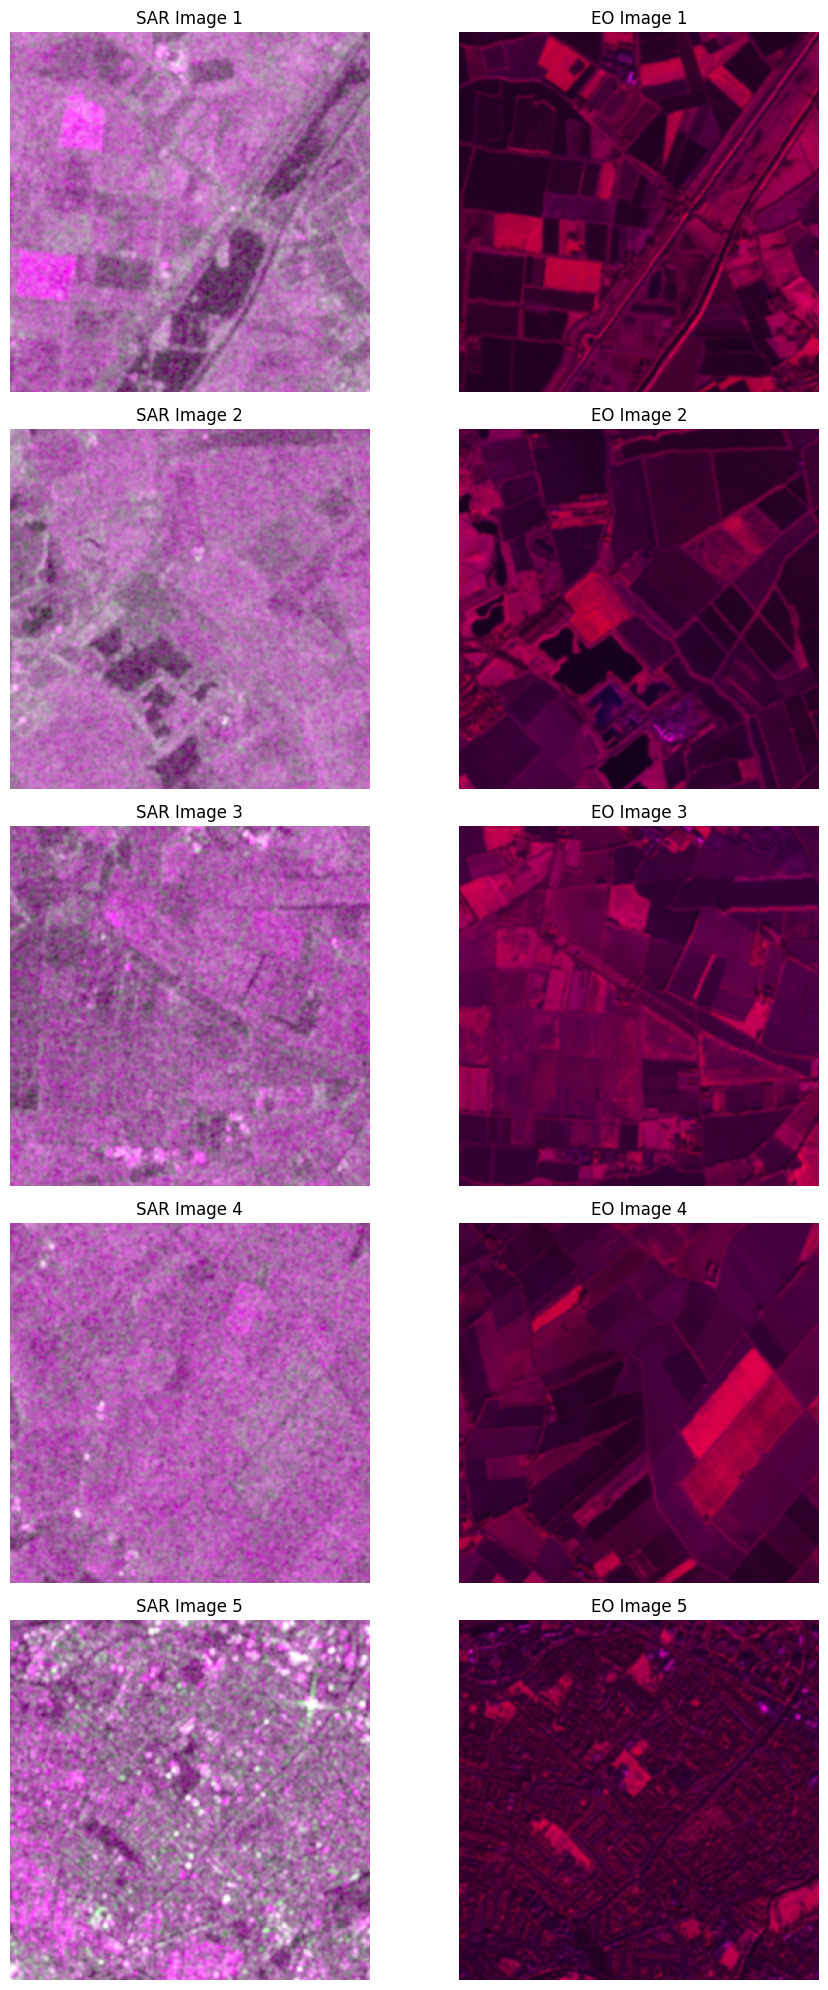

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Processed image folders
sar_dir = '/kaggle/working/processed_sar'
eo_dir = '/kaggle/working/processed_eo'

# Load filenames
sar_files = sorted(os.listdir(sar_dir))
eo_files = sorted(os.listdir(eo_dir))

# Number of pairs to show
num_samples = 5

plt.figure(figsize=(10, 4 * num_samples))

for i in range(num_samples):
    sar_img = Image.open(os.path.join(sar_dir, sar_files[i]))
    eo_img = Image.open(os.path.join(eo_dir, eo_files[i]))

    # SAR Image
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(sar_img)
    plt.title(f"SAR Image {i+1}")
    plt.axis('off')

    # EO Image
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(eo_img)
    plt.title(f"EO Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
from torchvision import transforms

# ----- SAR Transformations (with augmentation) -----
sar_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),       # Small rotation for SAR invariance
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# ----- EO Transformations (with augmentation) -----
eo_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),       # Light rotation for EO
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],    # Normalize each band
                         std=[0.5, 0.5, 0.5])
])


In [4]:
def extract_key(fname):
    return "_".join(fname.split("_")[3:])  # Gets "102_p215.png" from full name

sar_map = {extract_key(f): os.path.join(sar_dir, f) for f in os.listdir(sar_dir)}
eo_map = {extract_key(f): os.path.join(eo_dir, f) for f in os.listdir(eo_dir)}

common_keys = sorted(set(sar_map) & set(eo_map))

sar_paths = [sar_map[k] for k in common_keys]
eo_paths = [eo_map[k] for k in common_keys]

In [5]:
from sklearn.model_selection import train_test_split

sar_train, sar_test, eo_train, eo_test = train_test_split(
    sar_paths, eo_paths, test_size=0.2, random_state=42
)

In [6]:
import rasterio
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import functional as TF
import random

class PairedTransform:
    def __init__(self, apply_augmentation=True):
        self.apply_augmentation = apply_augmentation

    def __call__(self, sar, eo):
        # Random Horizontal Flip
        if self.apply_augmentation and random.random() > 0.5:
            sar = TF.hflip(sar)
            eo  = TF.hflip(eo)
        
        # Random Vertical Flip
        if self.apply_augmentation and random.random() > 0.5:
            sar = TF.vflip(sar)
            eo  = TF.vflip(eo)

        # Random Rotation
        if self.apply_augmentation:
            angle = random.uniform(-15, 15)
            sar = TF.rotate(sar, angle)
            eo  = TF.rotate(eo, angle)

        # To tensor
        sar = TF.to_tensor(sar)
        eo  = TF.to_tensor(eo)

        # Normalize
        sar = TF.normalize(sar, mean=[0.5], std=[0.5])
        eo  = TF.normalize(eo, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

        return sar, eo

class SAR2EO_Dataset(Dataset):
    def __init__(self, sar_paths, eo_paths, paired_transform):
        self.sar_paths = sar_paths
        self.eo_paths = eo_paths
        self.paired_transform = paired_transform

    def __len__(self):
        return min(len(self.sar_paths), len(self.eo_paths))

    def __getitem__(self, idx):
        sar = Image.open(self.sar_paths[idx]).convert('L')
        eo  = Image.open(self.eo_paths[idx]).convert('RGB')

        sar, eo = self.paired_transform(sar, eo)

        if sar.shape[0] == 1:
            sar = sar.repeat(3, 1, 1)  # to match EO input channels

        return sar, eo



In [7]:
from torch.utils.data import Dataset, DataLoader
train_transform = PairedTransform(apply_augmentation=True)
test_transform  = PairedTransform(apply_augmentation=False)

train_dataset = SAR2EO_Dataset(sar_train, eo_train, train_transform)
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset  = SAR2EO_Dataset(sar_test, eo_test, test_transform)
test_loader   = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [8]:
import torch
import torch.nn as nn

# ---------------------------------------------
# Helper Blocks
# ---------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x)

# ---------------------------------------------
# Generator (ResNet-based)
# ---------------------------------------------
class ResNetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2,
                                   padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, kernel_size=7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# ---------------------------------------------
# Discriminator (PatchGAN)
# ---------------------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super().__init__()
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        in_features = 64
        out_features = in_features * 2
        for _ in range(3):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        model += [
            nn.Conv2d(in_features, 1, kernel_size=4, padding=1)
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# ---------------------------------------------
# Utility: Initialize weights
# ---------------------------------------------
def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight.data, gain=init_gain)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
import torch
import itertools
import os
from torch import nn, optim
from torchvision.utils import save_image

# ---------------------------
# Model setup
# ---------------------------
G_AB = ResNetGenerator(input_nc=3, output_nc=3).to(device)  # SAR to EO
G_BA = ResNetGenerator(input_nc=3, output_nc=3).to(device)  # EO to SAR

D_A = Discriminator(input_nc=3).to(device)  # Discriminates SAR
D_B = Discriminator(input_nc=3).to(device)  # Discriminates EO

init_weights(G_AB)
init_weights(G_BA)
init_weights(D_A)
init_weights(D_B)

# ---------------------------
# Losses and Optimizers
# ---------------------------
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()
criterion_L1 = nn.L1Loss()  # 🔸 Added L1 loss for paired supervision

lambda_L1 = 100  # 🔸 Weight for L1 loss between fake EO and real EO

optimizer_G = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# ---------------------------
# Training
# ---------------------------
epochs = 10
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(epochs):
    for i, (real_A, real_B) in enumerate(train_loader):
        real_A = real_A.to(device)  # SAR image tensor
        real_B = real_B.to(device)  # EO image tensor

        # ---------------------------
        # Train Generators
        # ---------------------------
        optimizer_G.zero_grad()

        # Identity loss
        loss_idt_A = criterion_identity(G_BA(real_A), real_A) * 5.0
        loss_idt_B = criterion_identity(G_AB(real_B), real_B) * 5.0

        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B)))

        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)))

        # Cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A) * 10.0
        loss_cycle_B = criterion_cycle(recov_B, real_B) * 10.0

        # 🔸 New: L1 loss between fake EO and real EO (paired supervision)
        loss_L1_EO = criterion_L1(fake_B, real_B) * lambda_L1

        # Total generator loss
        loss_G = loss_idt_A + loss_idt_B + loss_GAN_AB + loss_GAN_BA + loss_cycle_A + loss_cycle_B + loss_L1_EO
        loss_G.backward()
        optimizer_G.step()

        # ---------------------------
        # Train Discriminator A (SAR)
        # ---------------------------
        optimizer_D_A.zero_grad()
        loss_real = criterion_GAN(D_A(real_A), torch.ones_like(D_A(real_A)))
        loss_fake = criterion_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A)))
        loss_D_A = (loss_real + loss_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # ---------------------------
        # Train Discriminator B (EO)
        # ---------------------------
        optimizer_D_B.zero_grad()
        loss_real = criterion_GAN(D_B(real_B), torch.ones_like(D_B(real_B)))
        loss_fake = criterion_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B)))
        loss_D_B = (loss_real + loss_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        # ---------------------------
        # Logging
        # ---------------------------
        if i % 20 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] [Batch {i+1}/{len(train_loader)}] "
                  f"[G: {loss_G.item():.4f}] [D_A: {loss_D_A.item():.4f}] [D_B: {loss_D_B.item():.4f}]")

    # ---------------------------
    # Save checkpoints
    # ---------------------------
    torch.save(G_AB.state_dict(), os.path.join(checkpoint_dir, f"G_AB_epoch{epoch+1}.pth"))
    torch.save(G_BA.state_dict(), os.path.join(checkpoint_dir, f"G_BA_epoch{epoch+1}.pth"))
    torch.save(D_A.state_dict(), os.path.join(checkpoint_dir, f"D_A_epoch{epoch+1}.pth"))
    torch.save(D_B.state_dict(), os.path.join(checkpoint_dir, f"D_B_epoch{epoch+1}.pth"))


[Epoch 1/10] [Batch 1/160] [G: 66.7427] [D_A: 1.8214] [D_B: 1.7660]
[Epoch 1/10] [Batch 21/160] [G: 52.4514] [D_A: 0.4473] [D_B: 0.5956]
[Epoch 1/10] [Batch 41/160] [G: 34.0771] [D_A: 0.5603] [D_B: 0.5518]
[Epoch 1/10] [Batch 61/160] [G: 26.9093] [D_A: 0.3469] [D_B: 0.2282]
[Epoch 1/10] [Batch 81/160] [G: 23.6705] [D_A: 0.3013] [D_B: 0.1518]
[Epoch 1/10] [Batch 101/160] [G: 27.1501] [D_A: 0.2539] [D_B: 0.1714]
[Epoch 1/10] [Batch 121/160] [G: 19.9278] [D_A: 0.3783] [D_B: 0.1973]
[Epoch 1/10] [Batch 141/160] [G: 37.9510] [D_A: 0.3741] [D_B: 0.1884]
[Epoch 2/10] [Batch 1/160] [G: 18.8036] [D_A: 0.2000] [D_B: 0.1873]
[Epoch 2/10] [Batch 21/160] [G: 15.2298] [D_A: 0.4495] [D_B: 0.1927]
[Epoch 2/10] [Batch 41/160] [G: 53.0580] [D_A: 0.2600] [D_B: 0.3669]
[Epoch 2/10] [Batch 61/160] [G: 11.9267] [D_A: 0.2597] [D_B: 0.0950]
[Epoch 2/10] [Batch 81/160] [G: 16.9134] [D_A: 0.2088] [D_B: 0.1117]
[Epoch 2/10] [Batch 101/160] [G: 10.8043] [D_A: 0.2666] [D_B: 0.1669]
[Epoch 2/10] [Batch 121/160] [G:

In [11]:
from torchvision.utils import save_image

G_A2B = ResNetGenerator(input_nc=3, output_nc=3).to(device)
G_A2B.load_state_dict(torch.load('/kaggle/working/checkpoints/G_AB_epoch10.pth', map_location=device))
G_A2B.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        

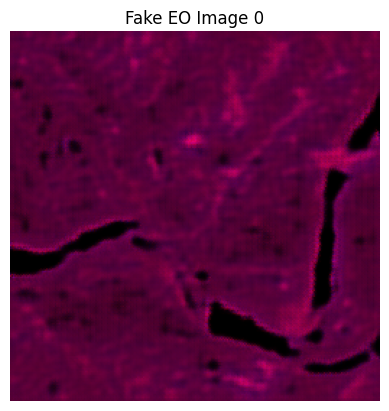

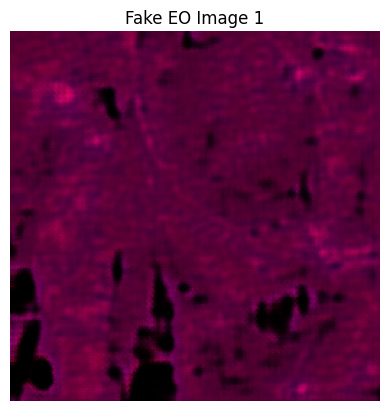

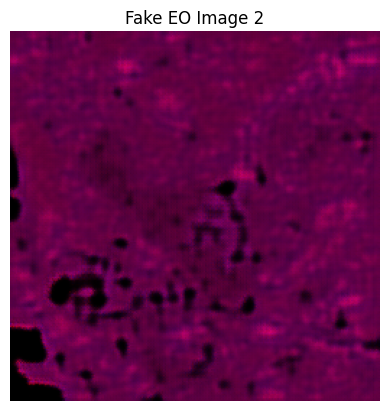

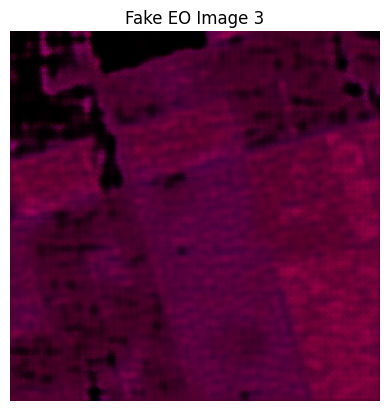

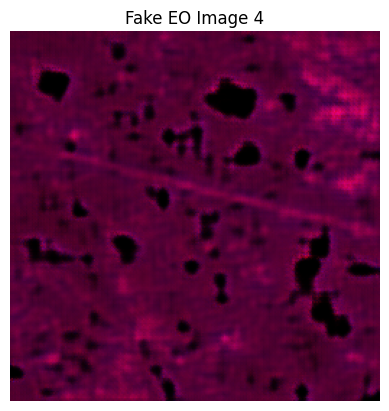

In [12]:
netG_A = ResNetGenerator(input_nc=3, output_nc=3).to(device)
netG_A.load_state_dict(torch.load('checkpoints/G_AB_epoch10.pth', map_location=device))
netG_A.eval()

for i, (sar_image, _) in enumerate(test_loader):  # '_' if EO not needed
    sar_image = sar_image.to(device)
    with torch.no_grad():
        fake_eo = netG_A(sar_image)  # call the generator instance

    # Denormalize from [-1,1] to [0,1]
    fake_eo = (fake_eo + 1) / 2.0
    np_img = fake_eo.squeeze().cpu().numpy().transpose(1, 2, 0)

    plt.imshow(np_img)
    plt.title(f'Fake EO Image {i}')
    plt.axis('off')
    plt.show()

    if i == 4:
        break

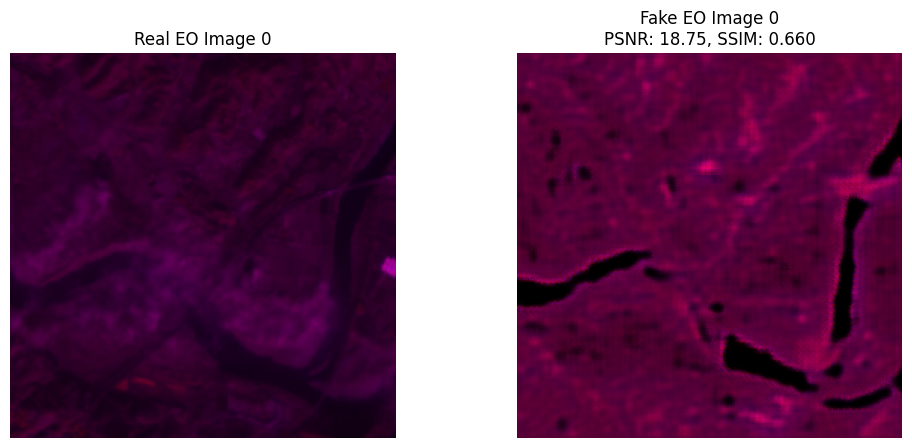

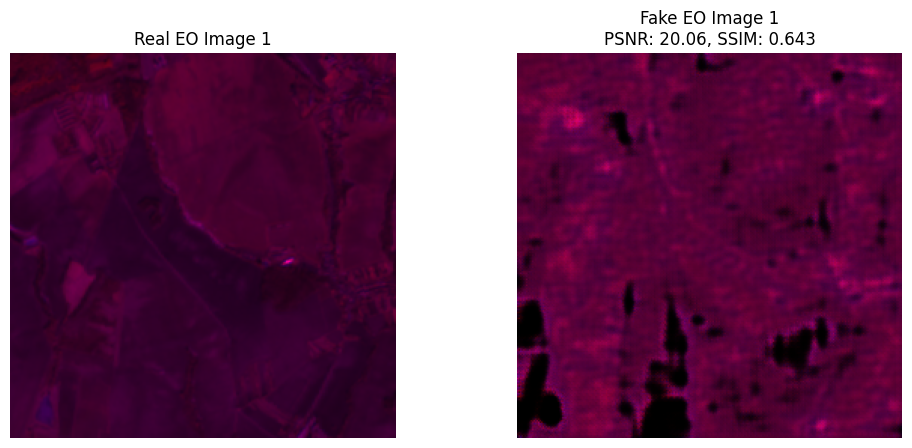

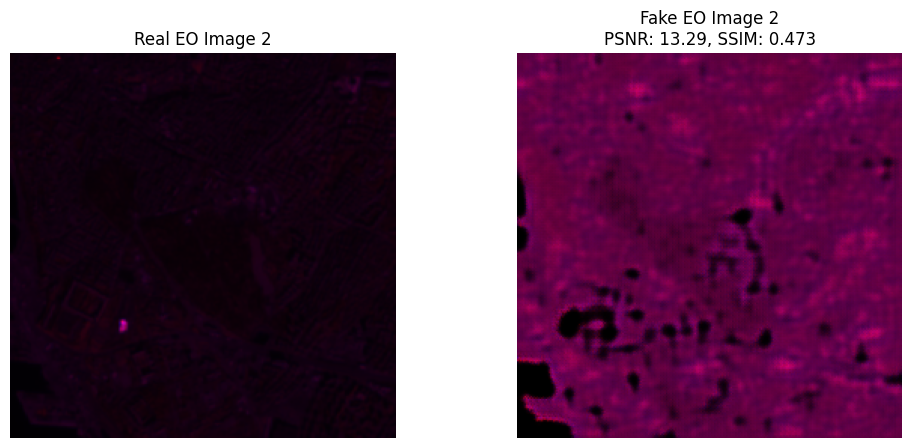

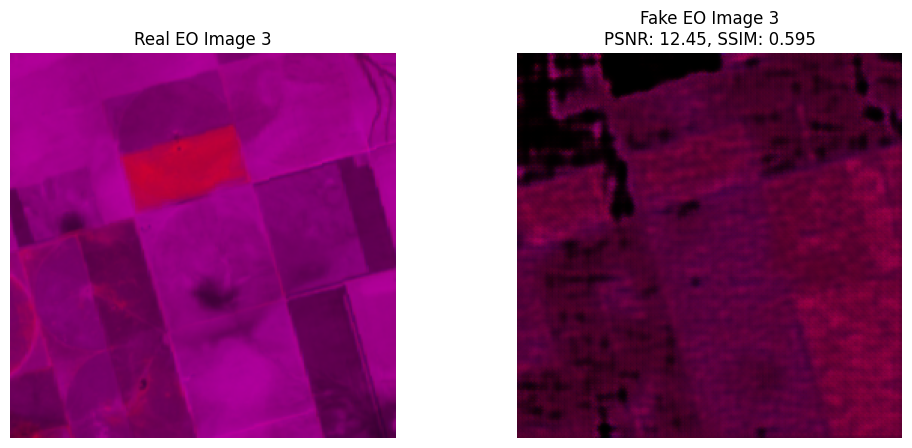

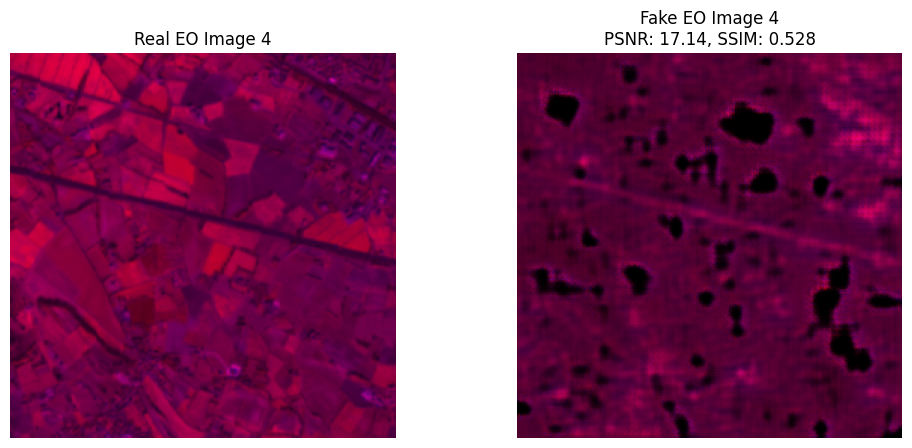

Average PSNR on test set: 16.49
Average SSIM on test set: 0.5542


In [13]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np
netG_A.eval()  # make sure eval mode

psnr_values = []
ssim_values = []

for i, (sar_image, real_eo) in enumerate(test_loader):
    sar_image = sar_image.to(device)
    real_eo = real_eo.to(device)

    with torch.no_grad():
        fake_eo = netG_A(sar_image)

    # Denormalize from [-1,1] to [0,1]
    fake_eo_np = (fake_eo + 1) / 2.0
    real_eo_np = (real_eo + 1) / 2.0

    # Convert to CPU numpy and transpose to HWC
    fake_eo_np = fake_eo_np.squeeze().cpu().numpy().transpose(1, 2, 0)
    real_eo_np = real_eo_np.squeeze().cpu().numpy().transpose(1, 2, 0)

    # Clip to [0,1]
    fake_eo_np = np.clip(fake_eo_np, 0, 1)
    real_eo_np = np.clip(real_eo_np, 0, 1)

    # Compute PSNR
    psnr_val = compare_psnr(real_eo_np, fake_eo_np, data_range=1.0)
    psnr_values.append(psnr_val)

    # Compute SSIM (multichannel=True for color images)
    ssim_val = compare_ssim(
    real_eo_np, fake_eo_np, 
    data_range=1.0, 
    channel_axis=2,  # specify channels are last axis
    win_size=5       # or smaller odd number <= min(H, W)
    )

    ssim_values.append(ssim_val)

    # Optional: visualize first few results
    if i < 5:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.title(f"Real EO Image {i}")
        plt.imshow(real_eo_np)
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title(f"Fake EO Image {i}\nPSNR: {psnr_val:.2f}, SSIM: {ssim_val:.3f}")
        plt.imshow(fake_eo_np)
        plt.axis('off')
        plt.show()

print(f"Average PSNR on test set: {np.mean(psnr_values):.2f}")
print(f"Average SSIM on test set: {np.mean(ssim_values):.4f}")